In [1]:
!pip install -r ./requirement.txt

  Using cached torch-2.0.1-cp310-cp310-win_amd64.whl (172.3 MB)
  Using cached torchvision-0.15.2-cp310-cp310-win_amd64.whl (1.2 MB)


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'D:\\Anaconda3\\Lib\\site-packages\\torch\\_C.cp310-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [1]:
from PIL import Image
import cv2
import torch
import math 
import function.utils_rotate as utils_rotate
from IPython.display import display
import os
import function.helper as helper

In [2]:
# load yolo model for detect and character detection stage
# please download yolov5 from our link on github
yolo_LP_detect = torch.hub.load('yolov5', 'custom', path='model/LP_detector.pt', force_reload=True, source='local')
yolo_license_plate = torch.hub.load('yolov5', 'custom', path='model/LP_ocr.pt', force_reload=True, source='local')

# set model confidence threshold 
# yolo_LP_detect.conf = 0.6
yolo_license_plate.conf = 0.60

C:\Users\ldvan\AppData\Roaming\Python\Python310\site-packages\torch\cuda\__init__.py:107: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ..\c10\cuda\CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
YOLOv5  v6.1-179-gf3fecf9 torch 2.0.1+cu117 CPU

Fusing layers... 
Model summary: 290 layers, 20852934 parameters, 0 gradients
Adding AutoShape... 
YOLOv5  v6.1-179-gf3fecf9 torch 2.0.1+cu117 CPU

Fusing layers... 
Model summary: 290 layers, 20970123 parameters, 0 gradients
Adding AutoShape... 


{'29D02-30242', '3D0A08711'}


C:\Users\ldvan\AppData\Local\Temp\ipykernel_2764\3928521506.py:41: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((basewidth,hsize), Image.ANTIALIAS)


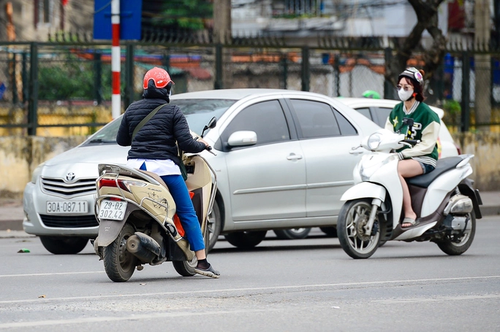

In [13]:
#enter image path here
img_file = "test_image/sa.jpg"
img = cv2.imread(img_file)
plates = yolo_LP_detect(img, size=640)
#-----------
list_plates = plates.pandas().xyxy[0].values.tolist()
list_read_plates = set()
count = 0
if len(list_plates) == 0:
    lp = helper.read_plate(yolo_license_plate,img)
    if lp != "unknown":
        list_read_plates.add(lp)
else:
    for plate in list_plates:
        flag = 0
        x = int(plate[0]) # xmin
        y = int(plate[1]) # ymin
        w = int(plate[2] - plate[0]) # xmax - xmin
        h = int(plate[3] - plate[1]) # ymax - ymin  
        crop_img = img[y:y+h, x:x+w]
        cv2.rectangle(img, (int(plate[0]),int(plate[1])), (int(plate[2]),int(plate[3])), color = (0,0,225), thickness = 2)
        cv2.imwrite("crop.jpg", crop_img)
        rc_image = cv2.imread("crop.jpg")
        lp = ""
        count+=1
        for cc in range(0,2):
            for ct in range(0,2):
                lp = helper.read_plate(yolo_license_plate, utils_rotate.deskew(crop_img, cc, ct))
                if lp != "unknown":
                    list_read_plates.add(lp)
                    flag = 1
                    break
            if flag == 1:
                break
#-----------
print(list_read_plates)
img = Image.open(img_file)
basewidth = 500
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.ANTIALIAS)
display(img)
#-------------
